In [1]:
import json
import pathlib

import scipy.stats
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style('whitegrid')

In [2]:
DATA_DIR = pathlib.Path('../data')
HEURISTICS = [
    'Solo Binary',
    'Joint Binary',
    'Solo Distance',
    'Joint Distance',
]

# Load data

In [3]:
def load_data(filepath):
    with open(filepath) as f:
        return json.load(f)

In [4]:
def to_record(experiment):
    return {
        'map': experiment['gs']['boardID'] + 1,
        'ticks': experiment['gs']['tick'],
        'heuristic': experiment['agentsParams'][0]['heuristic_method'],
    }

In [5]:
df = pd.DataFrame.from_records(to_record(x) for x in load_data(DATA_DIR / '200_ticks.json'))
df['success'] = df['ticks'] < df['ticks'].max()
df['solo'] = (df['heuristic'] % 2).astype(bool)
df['binary'] = df['heuristic'] < 3

# Success rate

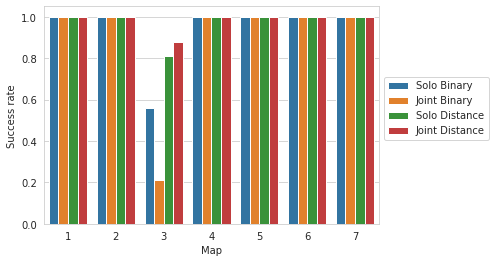

In [6]:
ax = sns.barplot(
    y='success',
    x='map',
    hue='heuristic',
    data=df.groupby(['map', 'heuristic']).mean().reset_index(),
)

# Axes
ax.set_xlabel('Map')
ax.set_ylabel('Success rate')

# Legend
handles, _ = ax.get_legend_handles_labels()
for handle, heuristic in zip(handles, HEURISTICS):
    handle.set_label(heuristic)
ax.legend(bbox_to_anchor=(1, 0.7))

Overall success rate

In [7]:
df['success'].mean()

0.945

Map 3 success rate

In [8]:
df[df['map'] == 3]['success'].mean()

0.615

# ANOVA

Successes only!

`ticks ~ solo * binary * map`

In [9]:
df = df[df['success']]

In [10]:
lm = smf.ols('ticks ~ C(solo) * C(binary) * C(map)', data=df).fit()

In [11]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ticks   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     195.7
Date:                Sat, 15 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:07:55   Log-Likelihood:                -10732.
No. Observations:                2646   AIC:                         2.152e+04
Df Residuals:                    2618   BIC:                         2.169e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        22.8100      1.405     16.238      0.000      20.055      25.565
C(solo)[T.True]                                   4.0400      1.987      2.034      0.042       0.144       7.936
C(binary)[T.True]                                -4.9300      1.987     -2.482      0.013      -8.826      -1.034
C(map)[T.2]                                      -0.4400      1.987     -0.221      0.825      -4.336       3.456
C(map)[T.3]                                      42.4059      2.053     20.653      0.000      38.380      46.432
C(map)[T.4]                                      -4.9000      1.987     -2.466      0.014      -8.796      -1.004
C(map)[T.5]                                      11.8000      1.987      5.940      0.000       7.904      15.696
C(map)[T.6]                                       1.8600      1.987      0.936      0.349      -2.036       5.756
C(map)[T.7]                                      -5.7300      1.987     -2.884      0.004      -9.626      -1.834
C(solo)[T.True]:C(binary)[T.True]                -3.6900      2.810     -1.313      0.189      -9.199       1.819
C(solo)[T.True]:C(map)[T.2]                       1.3700      2.810      0.488      0.626      -4.139       6.879
C(solo)[T.True]:C(map)[T.3]                       7.9169      2.937      2.696      0.007       2.158      13.676
C(solo)[T.True]:C(map)[T.4]                       3.8700      2.810      1.377      0.168      -1.639       9.379
C(solo)[T.True]:C(map)[T.5]                      -3.6300      2.810     -1.292      0.196      -9.139       1.879
C(solo)[T.True]:C(map)[T.6]                       3.4600      2.810      1.232      0.218      -2.049       8.969
C(solo)[T.True]:C(map)[T.7]                       3.6400      2.810      1.296      0.195      -1.869       9.149
C(binary)[T.True]:C(map)[T.2]                     6.4800      2.810      2.306      0.021       0.971      11.989
C(binary)[T.True]:C(map)[T.3]                    60.2379      3.948     15.258      0.000      52.497      67.979
C(binary)[T.True]:C(map)[T.4]                    11.9800      2.810      4.264      0.000       6.471      17.489
C(binary)[T.True]:C(map)[T.5]                    -2.4500      2.810     -0.872      0.383      -7.959       3.059
C(binary)[T.True]:C(map)[T.6]                     2.6400      2.810      0.940      0.347      -2.869       8.149
C(binary)[T.True]:C(map)[T.7]                    16.4300      2.810      5.848      0.000      10.921      21.939
C(solo)[T.True]:C(binary)[T.True]:C(map)[T.2]    -4.9000      3.973     -1.233      0.218     -12.691       2.891
C(solo)[T.True]:C(binary)[T.True]:C(map)[T.3]   -10.4336      5.049     -2.066      0.039     -20.334      -0.533
C(sol

In [12]:
aov_table = sm.stats.anova_lm(lm)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(solo),1.0,15225.765525,15225.765525,77.157530,2.796836e-18
C(binary),1.0,3474.791951,3474.791951,17.608728,2.803775e-05
C(map),6.0,870508.954865,145084.825811,735.226537,0.000000e+00
C(solo):C(binary),1.0,5731.219229,5731.219229,29.043316,7.708793e-08
C(solo):C(map),6.0,14160.940657,2360.156776,11.960244,2.737262e-13
C(binary):C(map),6.0,121020.297397,20170.049566,102.213003,6.990522e-116
C(solo):C(binary):C(map),6.0,12621.823610,2103.637268,10.660315,9.856165e-12
Residual,2618.0,516619.103212,197.333500,NaN,NaN


[Reference for eta_sq](https://pythonfordatascience.org/anova-python/).

In [13]:
def eta_sq(aov):
    result = aov['sum_sq'] / aov['sum_sq'].sum()
    return result.rename('eta_sq')

eta_sq(aov_table)

C(solo)                     0.009764
C(binary)                   0.002228
C(map)                      0.558247
C(solo):C(binary)           0.003675
C(solo):C(map)              0.009081
C(binary):C(map)            0.077609
C(solo):C(binary):C(map)    0.008094
Residual                    0.331301
Name: eta_sq, dtype: float64

## More plots

Text(0.5, 6.800000000000029, 'Map')

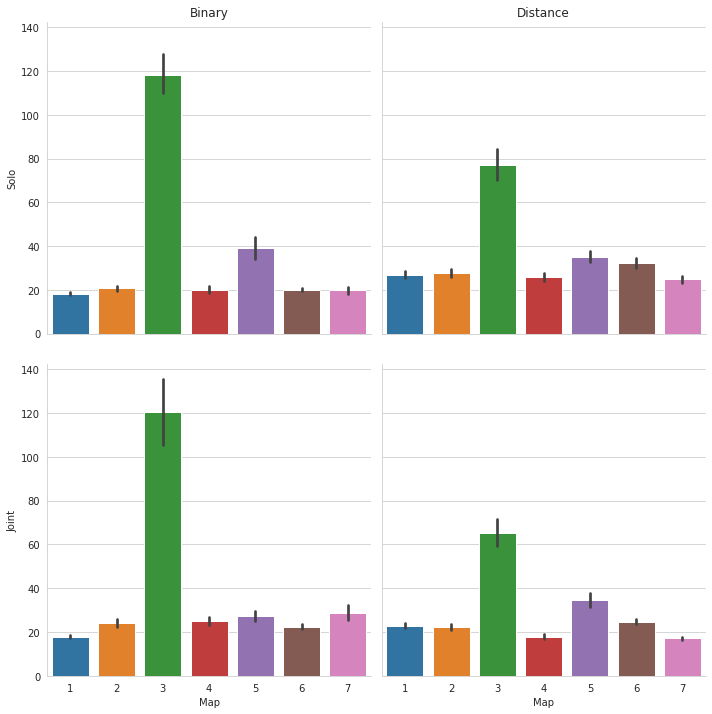

In [14]:
ax = sns.catplot(
    y='ticks',
    x='map',
    col='binary',
    row='solo',
    data=df,
    kind='bar',
    col_order=[True, False],
    row_order=[True, False],
)

ax.axes[0, 0].set_title('Binary')
ax.axes[0, 1].set_title('Distance')
ax.axes[1, 0].set_title('')
ax.axes[1, 1].set_title('')

ax.axes[0, 0].set_ylabel('Solo')
ax.axes[1, 0].set_ylabel('Joint')

ax.axes[1, 0].set_xlabel('Map')
ax.axes[1, 1].set_xlabel('Map')

# Optimised heuristic 4 (Joint Distance) vs. overall optimised params

In [15]:
filename = '200_ticks_optimised_heuristic_4_vs_best_ntbea.json'
df = pd.DataFrame.from_records(to_record(x) for x in load_data(DATA_DIR / filename))
df['success'] = df['ticks'] < df['ticks'].max()
df['solo'] = (df['heuristic'] % 2).astype(bool)
df['binary'] = df['heuristic'] < 3

In [16]:
# 700 iterations of heuristic 4 specific parameters and 700 for NTBEA best parameters
df['specific'] = [True] * 700 + [False] * 700

## Success rate

Are we doing better than NTBEA optimisation?

In [17]:
df.groupby(['specific', 'success'])['specific'].count().unstack()

success,False,True
specific,,
False,25,675
True,7,693


In [18]:
scipy.stats.chisquare(
    f_exp=df[df['specific'] == True]['success'].value_counts(),
    f_obs=df[df['specific'] == False]['success'].value_counts(),
)

Power_divergenceResult(statistic=46.75324675324675, pvalue=8.051143914526878e-12)

## Performance

Success only.

Are we doing better than NTBEA optimisation?

In [19]:
df = df[df['success']]

In [20]:
df.groupby(['specific'])['ticks'].mean()

specific
False    30.669630
True     29.704185
Name: ticks, dtype: float64

In [21]:
scipy.stats.ttest_ind(
    df[df['specific'] == True]['ticks'],
    df[df['specific'] == False]['ticks'],
)

Ttest_indResult(statistic=-0.8056434681061311, pvalue=0.42058867109030773)

In [22]:
degree_of_freedom = len(df) - 2
degree_of_freedom

1366